## Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
from scipy import stats
from multiprocessing import Pool, cpu_count
from functools import partial

# Import custom modules
import data_utils
import analysis
import plotting

%matplotlib inline

## Configuration

In [2]:
DATA_DIR = "data"
PLOTS_DIR = "plots"
REGPLOTS_DIR = "regplots"

# Create output directories
os.makedirs(PLOTS_DIR, exist_ok=True)
os.makedirs(REGPLOTS_DIR, exist_ok=True)
os.makedirs("IE-plots", exist_ok=True)
os.makedirs("IE-regplots", exist_ok=True)
os.makedirs("noIE-plots", exist_ok=True)
os.makedirs("noIE-regplots", exist_ok=True)

plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11

## 1. Load Data

In [3]:
# Load metadata
metadata = data_utils.load_metadata(os.path.join(DATA_DIR, 'metadata.pkl'))

langNames = metadata['langNames']
langnameGroup = metadata['langnameGroup']
group2lang = metadata['group2lang']
appearance_dict = metadata['appearance_dict']

print(f"Languages: {len(langNames)}")
print(f"Groups: {len(set(langnameGroup.values()))}")

Loaded metadata from data/metadata.pkl
Languages: 186
Groups: 11


In [4]:
# Load analysis results
results = analysis.load_analysis_results(DATA_DIR)

all_langs_position2num = results['all_langs_position2num']
all_langs_position2sizes = results['all_langs_position2sizes']
all_langs_average_sizes = results['all_langs_average_sizes']
filtered_position2num = results['filtered_position2num']
filtered_position2sizes = results['filtered_position2sizes']
lang2MAL = results['lang2MAL']

# Use filtered data for plotting
all_langs_average_sizes_filtered = all_langs_average_sizes

print(f"Languages with results: {len(all_langs_average_sizes)}")

Loaded all_langs_position2num.pkl
Loaded all_langs_position2sizes.pkl
Loaded all_langs_average_sizes.pkl
Loaded filtered_position2num.pkl
Loaded filtered_position2sizes.pkl
Loaded lang2MAL.pkl
All analysis results loaded from data/
Languages with results: 186


## 2. Create Color Palettes

Create color palettes for:
- Language groups (all languages)
- Indo-European genera (IE languages only)

In [5]:
# Group-level color palette (already in appearance_dict)
group_to_color = appearance_dict
print(f"Language groups with colors: {len(group_to_color)}")
print("Sample:", list(group_to_color.items())[:5])

Language groups with colors: 29
Sample: [('Italic', 'brown'), ('Baltoslavic', 'purple'), ('Germanic', 'olive'), ('Indo-European', 'royalBlue'), ('Austronesian', 'limeGreen')]


In [6]:
# Create Indo-European genus color palette
# First, identify IE languages and their genera
# This requires loading the language_to_group sheet which has genus information
sheets_data = data_utils.load_google_sheets(
    metadata.get('credentials_file', 'typometrics-c4750cac2e21.json'),
    metadata.get('spreadsheet_url', 'https://docs.google.com/spreadsheets/d/1IP3ebsNNVAsQ5sxmBnfEAmZc4f0iotAL9hd4aqOOcEg/edit')
)

language_to_group_df = sheets_data['dataframes']['language_to_group']
langnameGenus = language_to_group_df.set_index('Language').to_dict()['Genus']

# Filter to only IE languages
IElangnameGenus = {
    lang: langnameGenus[lang] 
    for lang in langnameGroup 
    if langnameGroup[lang] == 'Indo-European' and lang in langnameGenus
}

# Create color palette for IE genera
ie_genera = sorted(set(IElangnameGenus.values()))
ie_palette = sns.color_palette("husl", len(ie_genera))
IEgenus_to_color = dict(zip(ie_genera, ie_palette))

print(f"IE genera: {len(ie_genera)}")
print("Sample:", list(IEgenus_to_color.keys())[:5])

IE genera: 9
Sample: ['', 'Baltoslavic', 'Celtic', 'Germanic', 'Hellenic']


## 3. Define Helper Functions

The main plotting function `plot_dependency_sizes` is now in the `plotting` module.

In [7]:
def _plot_task(args):
    """Helper function for parallel plotting."""
    (pos1_str, pos2_str, prefix, all_langs_average_sizes_filtered, 
     filter_lang, langNames, langnameGroup, langname_group_or_genus, 
     folderprefix, palette) = args
    
    plotting.plot_dependency_sizes(
        pos1_str, 
        pos2_str, 
        prefix,
        all_langs_average_sizes_filtered,  
        filter_lang=filter_lang,
        langNames=langNames,
        langnameGroup=langnameGroup,
        langname_group_or_genus=langname_group_or_genus,               
        folderprefix=folderprefix, 
        palette=palette,
        show_inline=False  # Don't show inline for batch processing
    )
    return f"{prefix}: {pos1_str} vs {pos2_str}"


def plot_all(filter_lang, langname_group_or_genus=None, folderprefix='', palette=None, parallel=True):
    """
    Plot all dependency size comparisons.
    
    Parameters
    ----------
    filter_lang : function
        Function to filter languages
    langname_group_or_genus : dict
        Mapping of language names to groups or genera
    folderprefix : str
        Prefix for output folders
    palette : dict
        Color palette
    parallel : bool
        Whether to use parallel processing (default True)
    """
    if langname_group_or_genus is None:
        langname_group_or_genus = langnameGroup
    if palette is None:
        palette = group_to_color
    
    print(f'_________________________ plotting all ___________________________ {folderprefix}')
    
    measures = [
        ('MAL', 'right_{k}_totright_{m}', 'right_{k}_totright_{n}', [1,5], [1,5]), # MAL comparison
        ('MAL', 'left_{k}_totleft_{m}', 'left_{k}_totleft_{n}', [1,5], [1,5]), # MAL left side
        ('HCS', 'right_{j}_totright_{n}', 'right_{k}_totright_{n}', [2,6], [2,6]), # HCS comparison
        ('HCS', 'left_{k}_totleft_{n}', 'left_{j}_totleft_{n}', [2,6], [2,6]), # HCS left side - SWAPPED j and k
        ('DIAG', 'right_{k}_totright_{n}', 'right_{l}_totright_{m}', [1,5], [1,5]), # Diagonal comparison
        ('DIAG', 'left_{k}_totleft_{n}', 'left_{l}_totleft_{m}', [1,5], [1,5]), # Diagonal left side
    ]
    
    # Build list of all plot tasks
    tasks = []
    for (prefix, pos1, pos2, n_range, k_range) in measures:
        for n in range(*n_range):
            for k in range(*k_range):
                if k <= n:
                    m = n + 1
                    j = k - 1
                    l = k + 1
                    pos1_str = pos1.format(n=n, k=k, m=m, j=j, l=l)
                    pos2_str = pos2.format(n=n, k=k, m=m, j=j, l=l)
                    
                    tasks.append((
                        pos1_str, pos2_str, prefix, all_langs_average_sizes_filtered,
                        filter_lang, langNames, langnameGroup, langname_group_or_genus,
                        folderprefix, palette
                    ))
    
    print(f"Total plots to generate: {len(tasks)}")
    
    if parallel:
        # Use multiprocessing for parallel execution
        num_cores = cpu_count()
        print(f"Using {num_cores} CPU cores for parallel processing")
        
        with Pool(processes=num_cores) as pool:
            results = pool.map(_plot_task, tasks)
        
        print(f"\n✅ Completed {len(results)} plots")
    else:
        # Sequential execution (original behavior)
        for task in tasks:
            result = _plot_task(task)
            print(result)

## 4. Test Plots with Sample Comparisons

Before generating all plots, test the plotting functions with a few sample comparisons to verify the output.

In [8]:
# Define filter functions for testing
def filter_lang_all(lang):
    """Include all languages."""
    return True


Testing left side: left_1 vs left_2
✓ Saved plot: plots/TEST_LEFT_left_1_vs_left_2.png
✓ Saved plot: plots/TEST_LEFT_left_1_vs_left_2.png


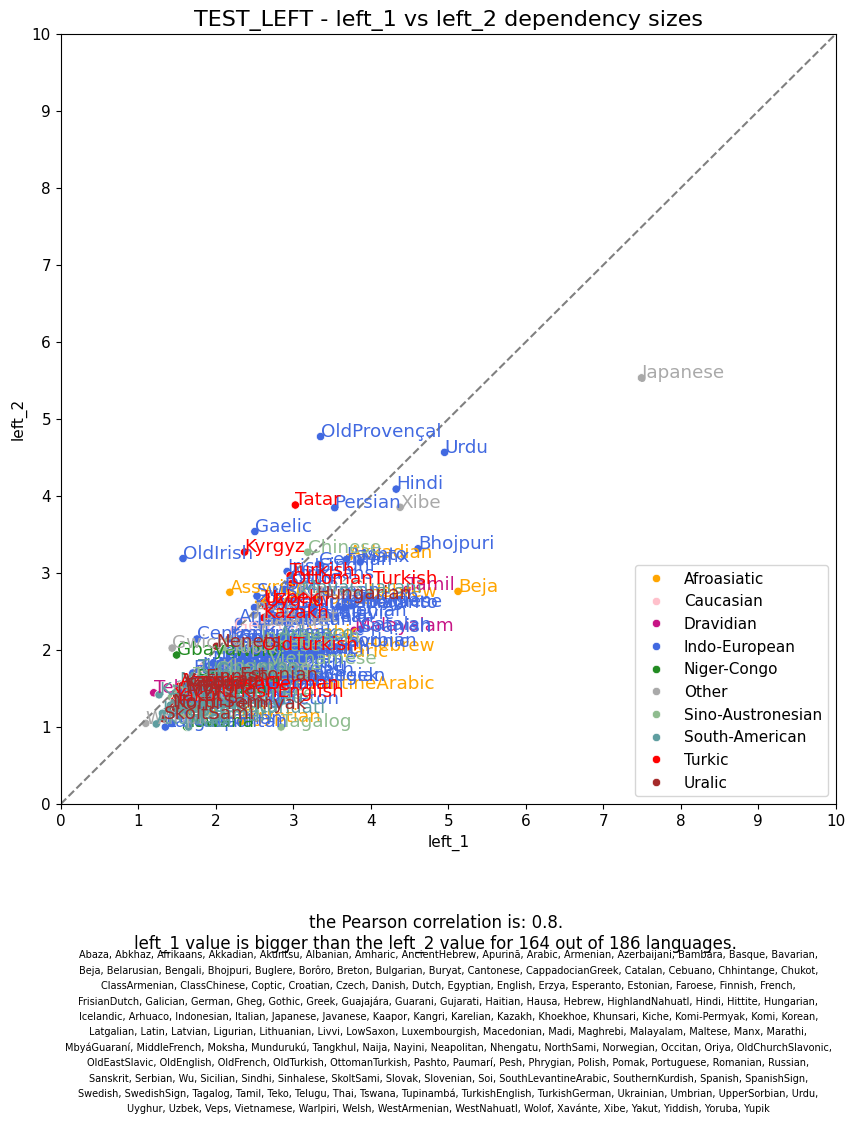

✓ Saved regression plot: regplots/TEST_LEFT_left_1_vs_left_2 regplot.png


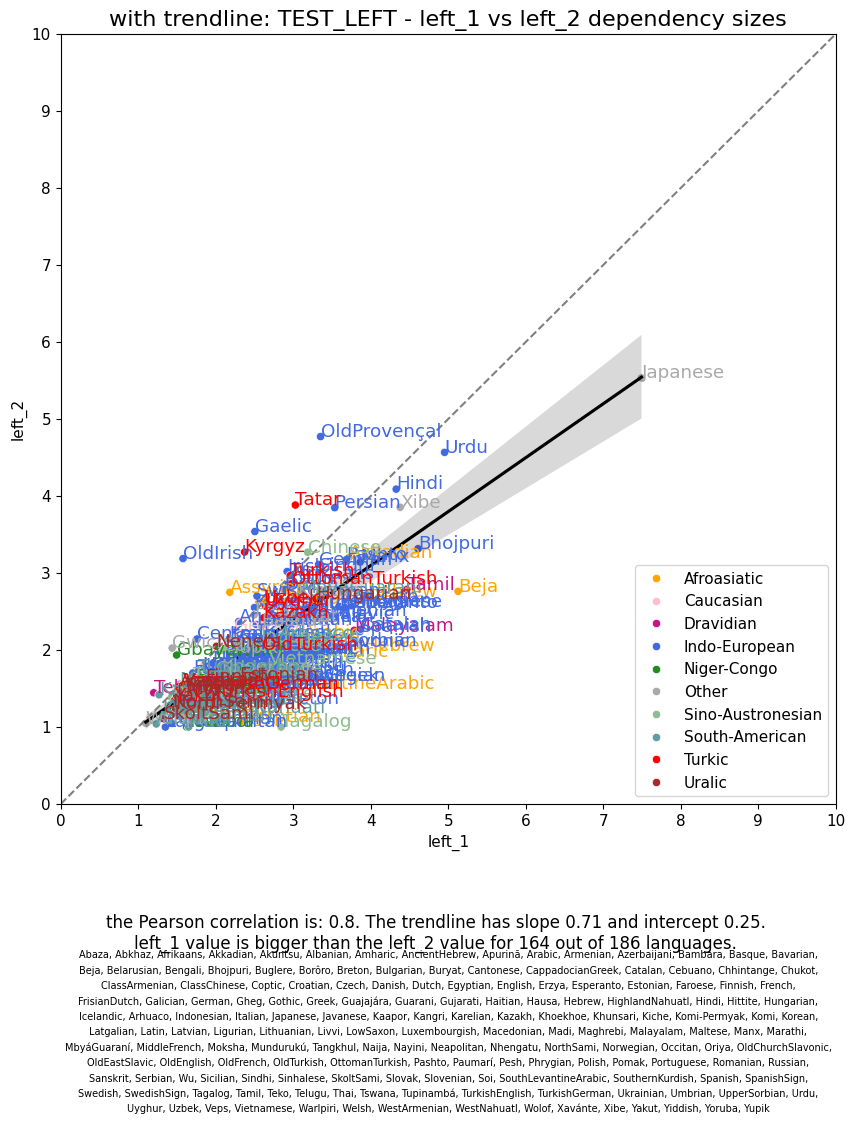

In [9]:
# Test left side comparison
print("\nTesting left side: left_1 vs left_2")
plotting.plot_dependency_sizes(
    'left_1', 
    'left_2', 
    'TEST_LEFT',
    all_langs_average_sizes_filtered,  
    filter_lang=filter_lang_all,
    langNames=langNames,
    langnameGroup=langnameGroup,
    langname_group_or_genus=langnameGroup,               
    folderprefix='', 

    palette=group_to_color)


Testing MAL comparison: right_1_totright_2 vs right_1_totright_1


✓ Saved plot: plots/TEST_MAL_right_1_totright_2_vs_right_1_totright_1.png


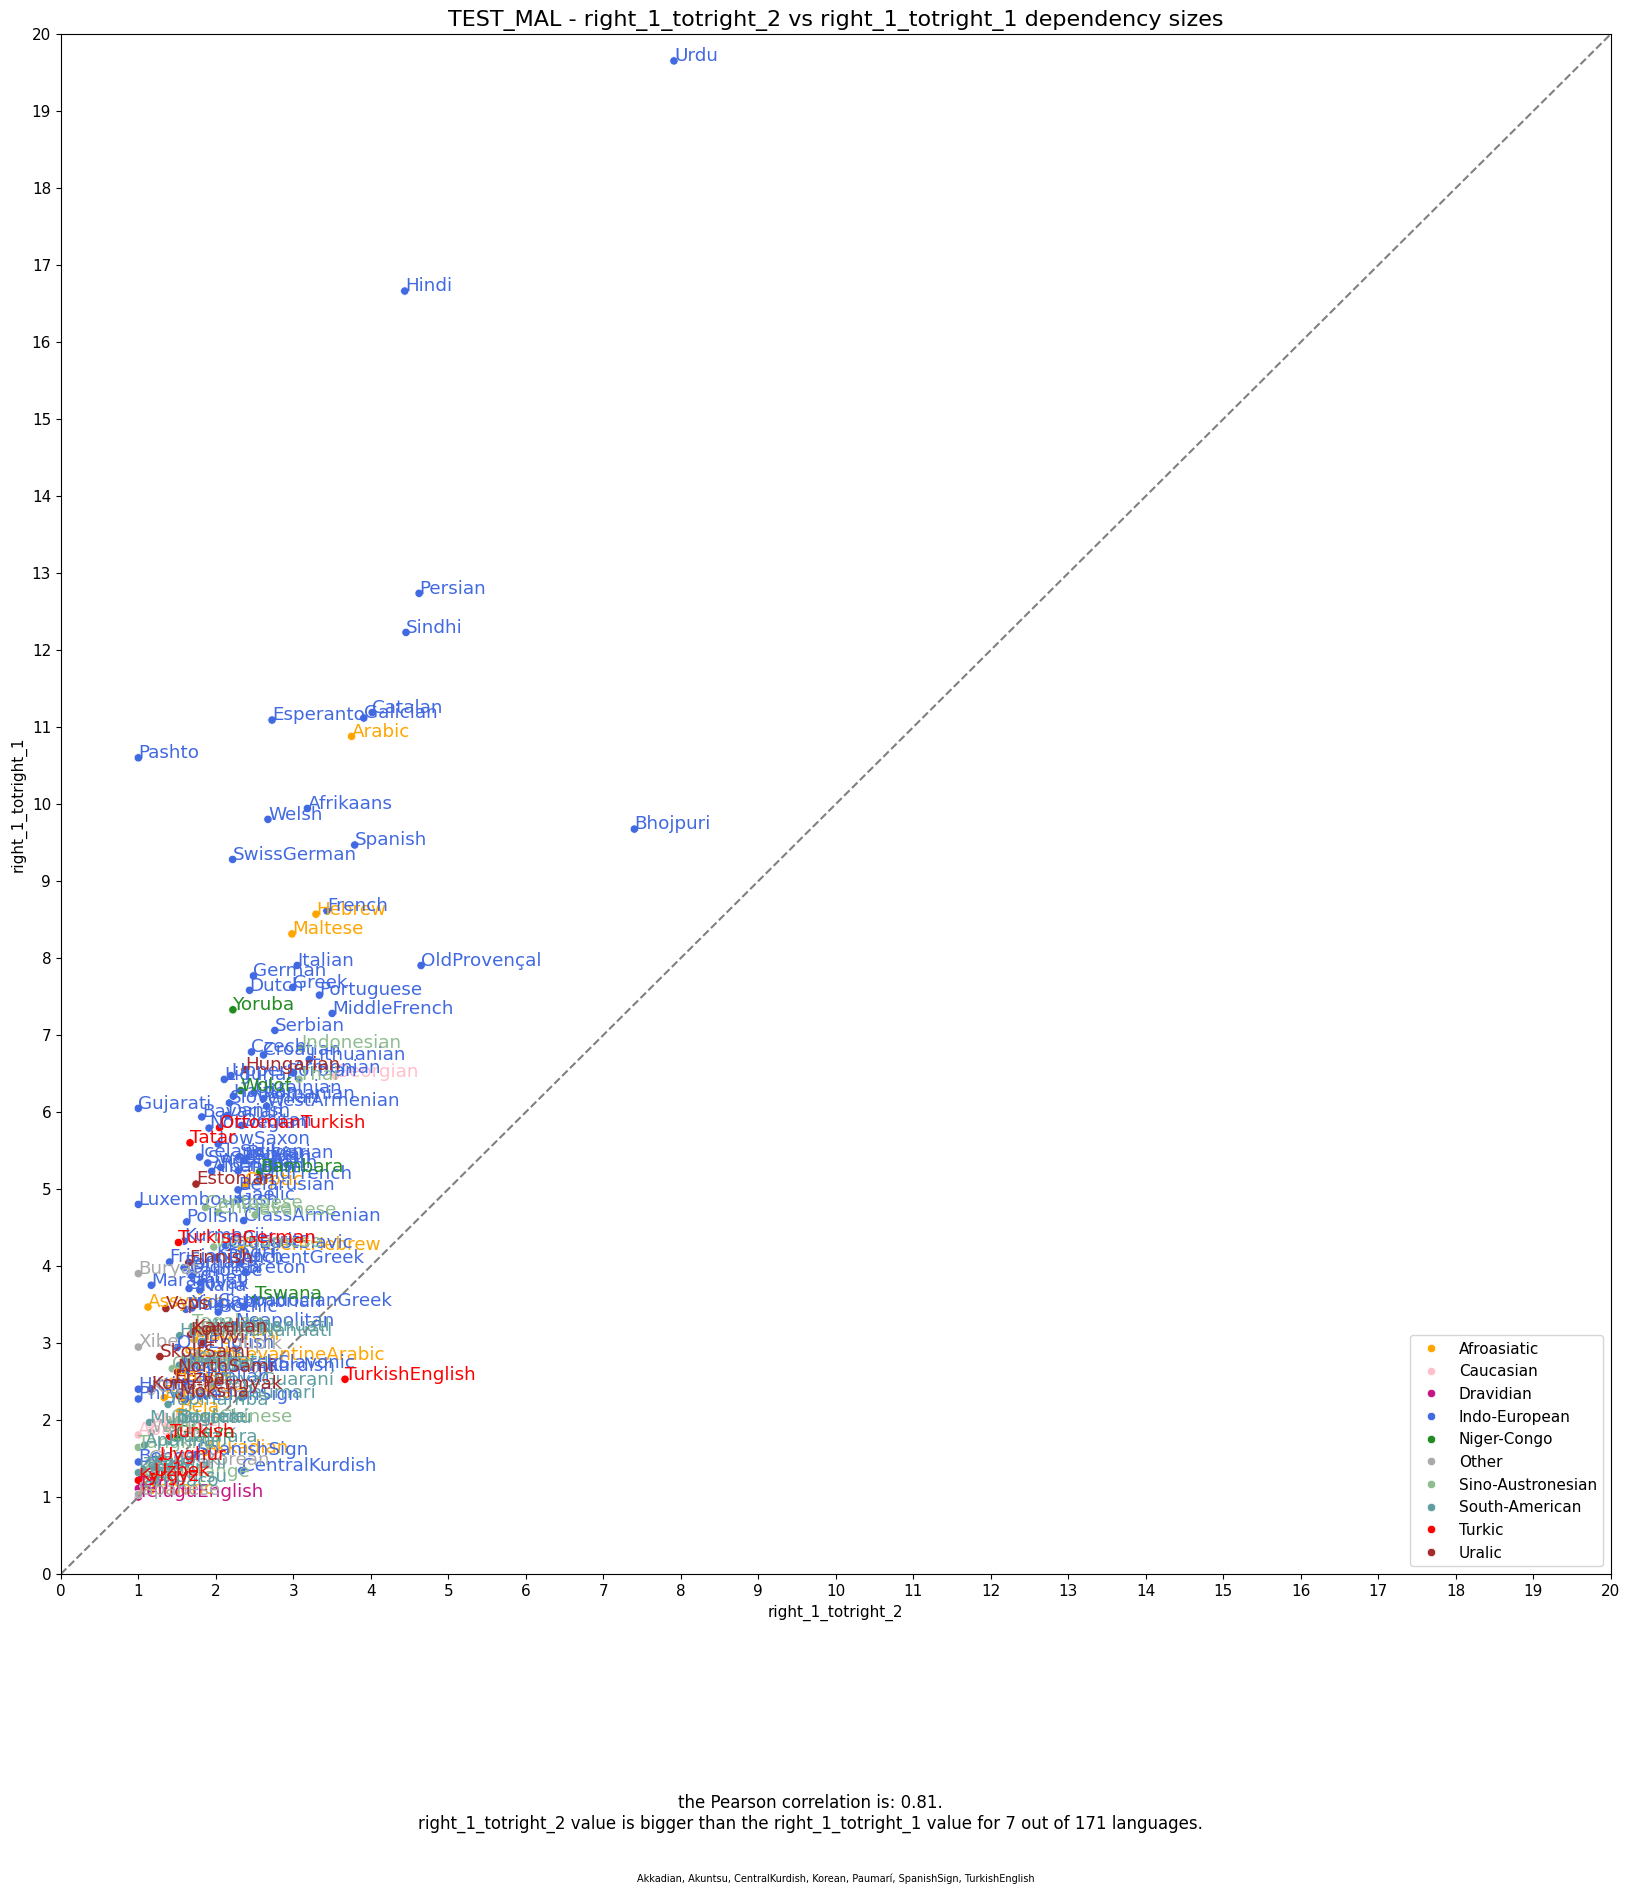

✓ Saved regression plot: regplots/TEST_MAL_right_1_totright_2_vs_right_1_totright_1 regplot.png


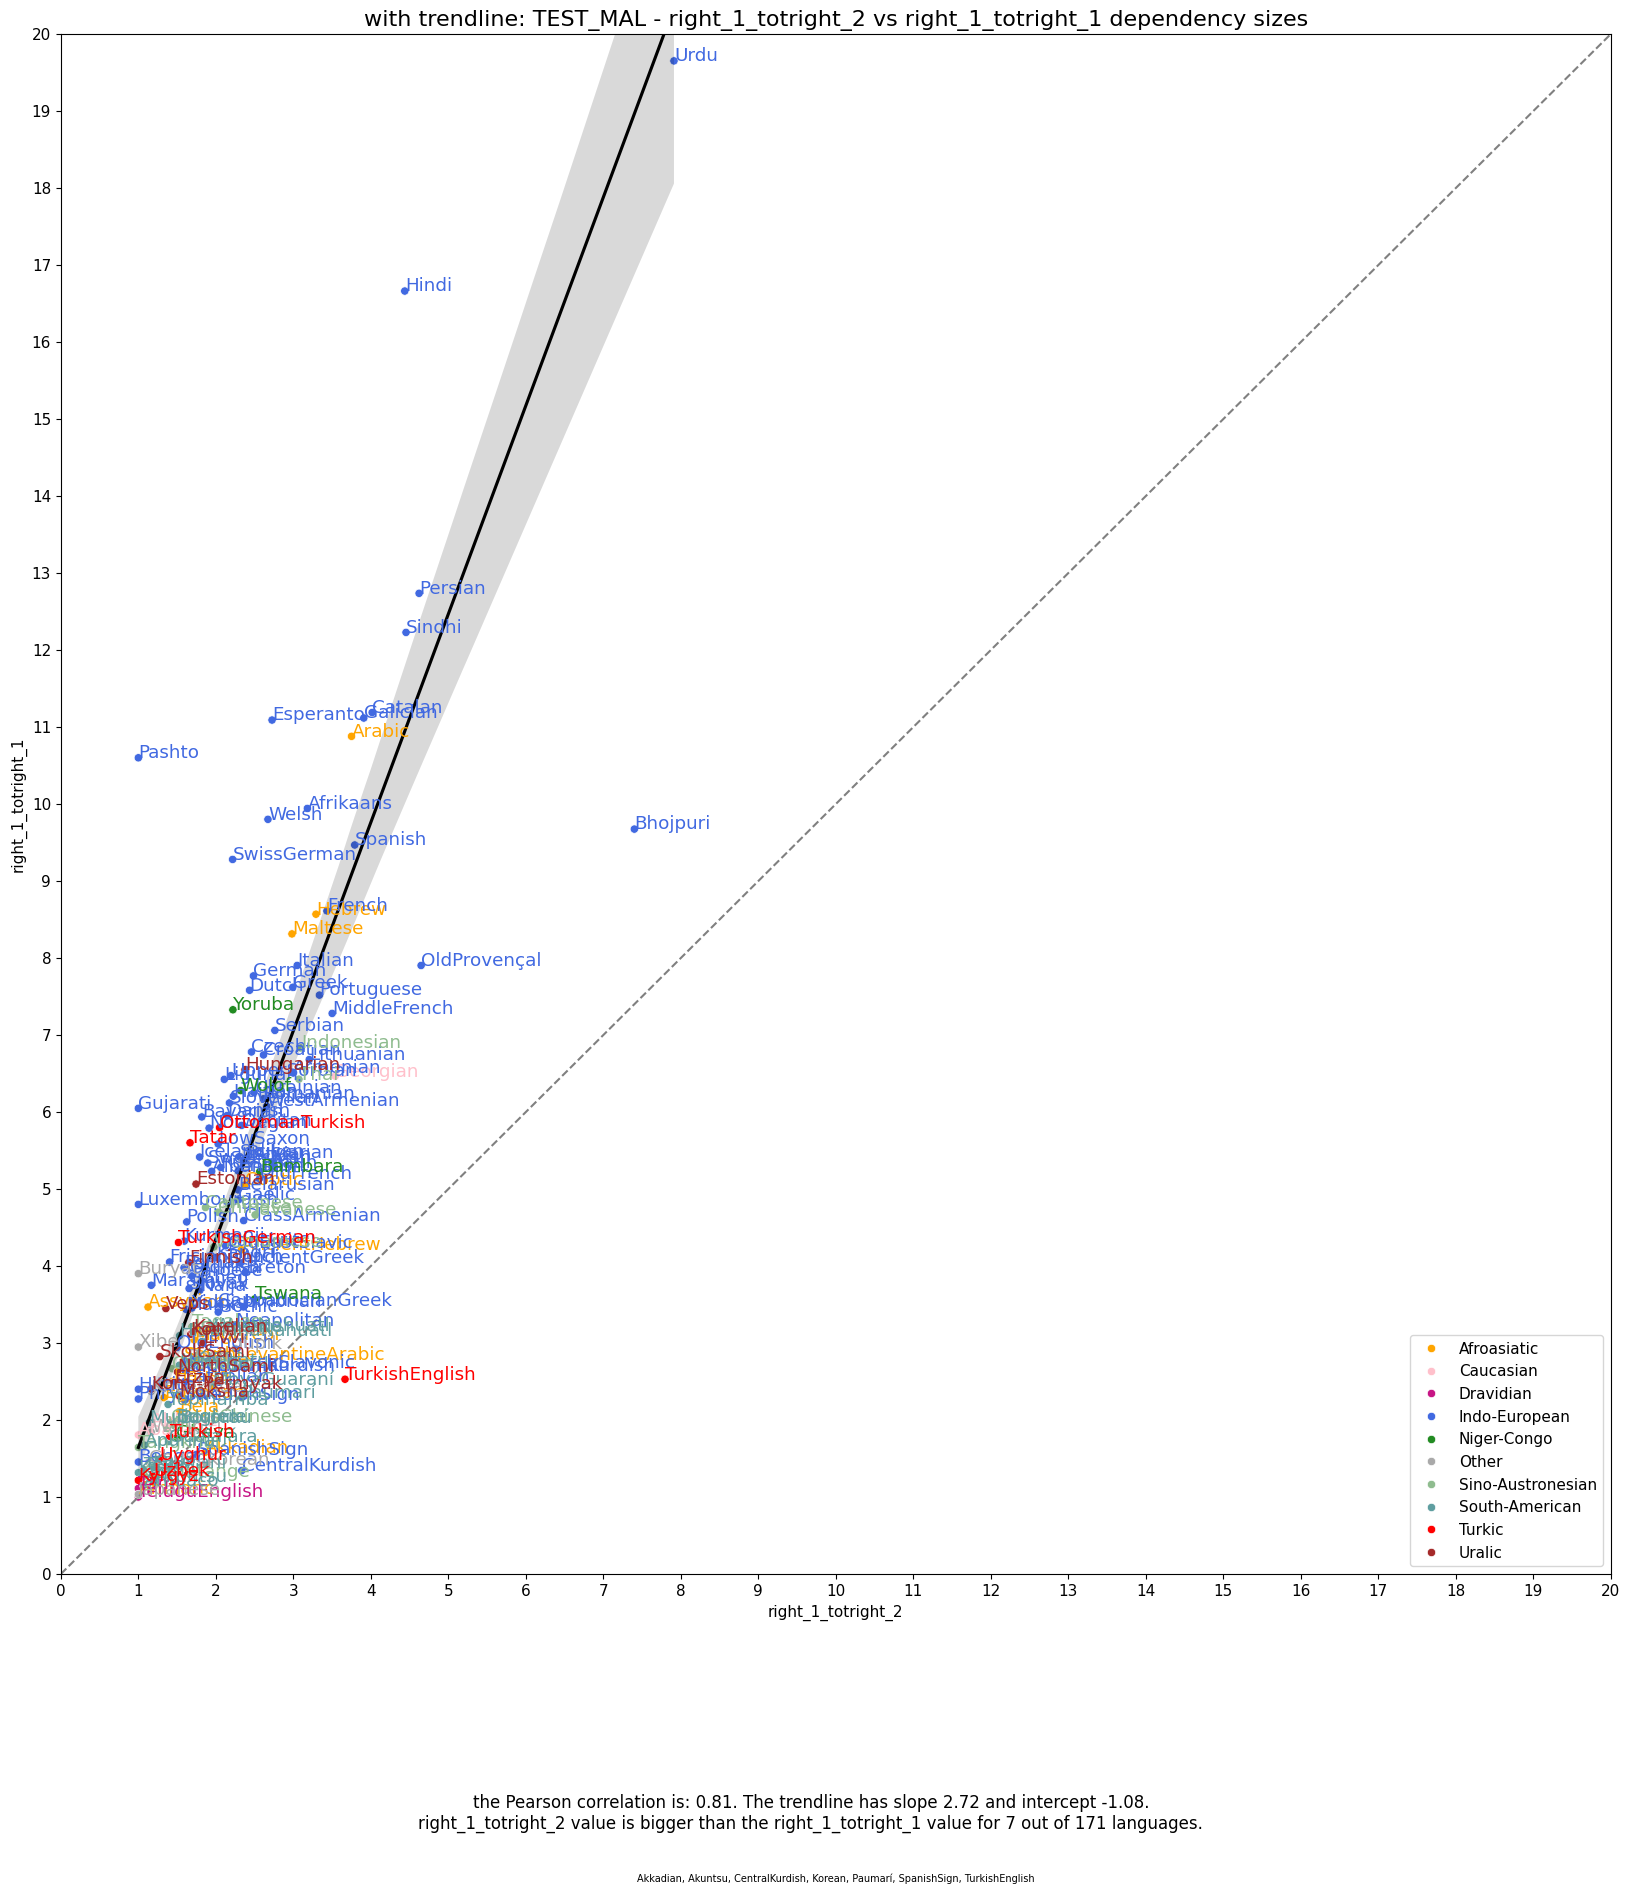

In [10]:
# Test MAL comparison: right_1_totright_2 vs right_1_totright_1
print("\nTesting MAL comparison: right_1_totright_2 vs right_1_totright_1")
plotting.plot_dependency_sizes(
    'right_1_totright_2', 
    'right_1_totright_1', 
    'TEST_MAL',
    all_langs_average_sizes_filtered,  
    filter_lang=filter_lang_all,
    langNames=langNames,
    langnameGroup=langnameGroup,
    langname_group_or_genus=langnameGroup,               
    folderprefix='', 

    palette=group_to_color)

Testing plot_dependency_sizes with right_1 vs right_2


✓ Saved plot: plots/TEST_right_1_vs_right_2.png


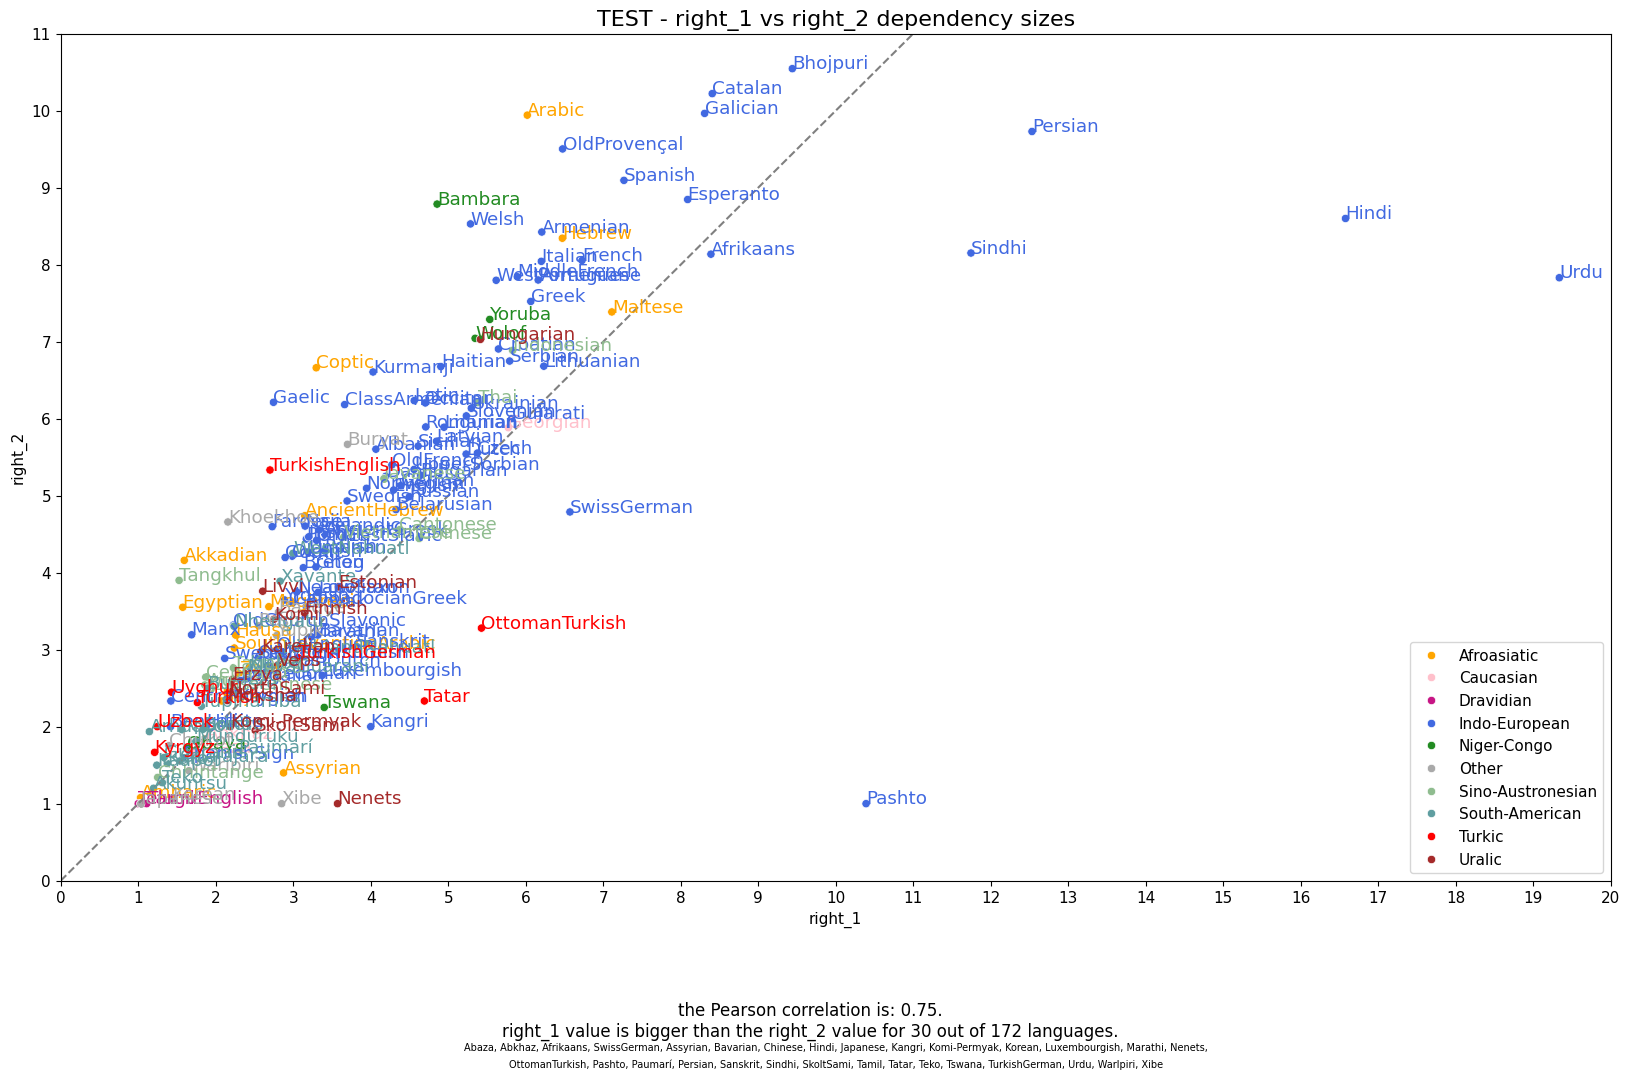

✓ Saved regression plot: regplots/TEST_right_1_vs_right_2 regplot.png


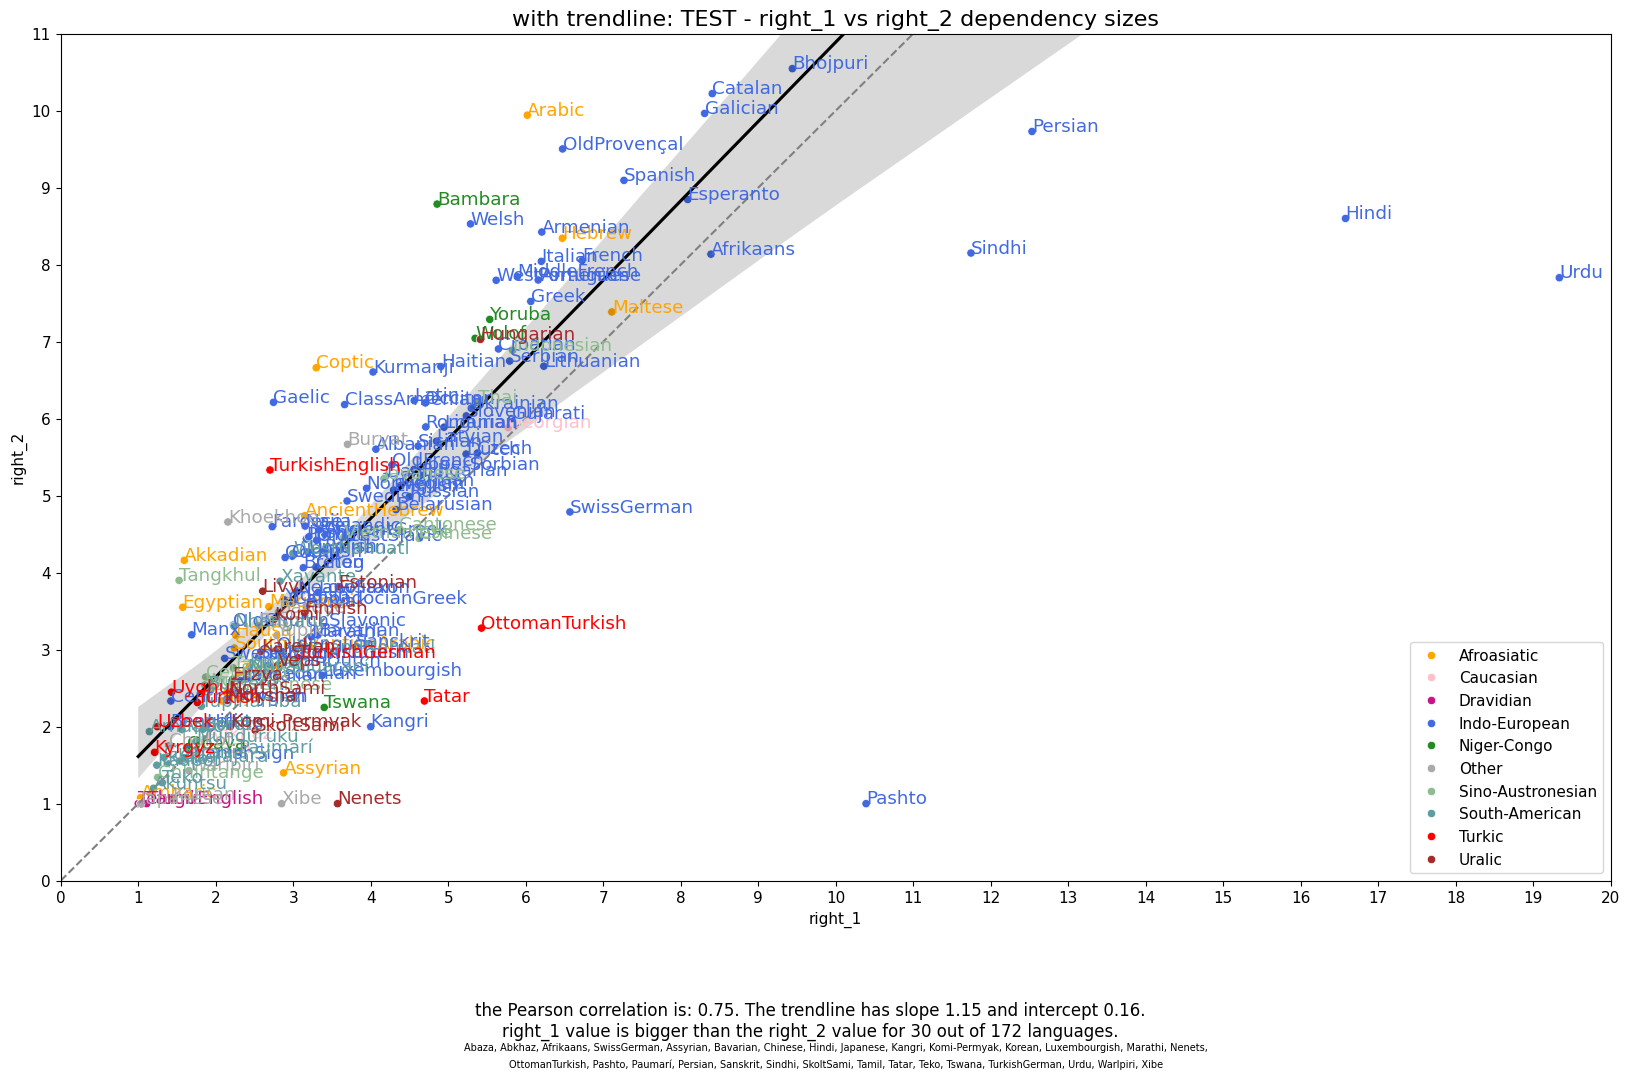

In [11]:
# Test with a simple comparison: right_1 vs right_2
print("Testing plot_dependency_sizes with right_1 vs right_2")
plotting.plot_dependency_sizes(
    'right_1', 
    'right_2', 
    'TEST',
    all_langs_average_sizes_filtered,  
    filter_lang=filter_lang_all,
    langNames=langNames,
    langnameGroup=langnameGroup,
    langname_group_or_genus=langnameGroup,               
    folderprefix='', 

    palette=group_to_color)

## 5. Generate Plots: All Languages

Generate all scatter plots for all languages (this will take some time).

In [12]:
# Generate all plots for all languages
plot_all(filter_lang_all)

_________________________ plotting all ___________________________ 
Total plots to generate: 60
Using 80 CPU cores for parallel processing
✓ Saved plot: plots/right pos 1 tot 5 vs tot 4 MAL.png
✓ Saved plot: plots/right pos 1 tot 5 vs tot 4 MAL.png
✓ Saved plot: plots/right pos 1 tot 3 vs tot 2 MAL.png
✓ Saved plot: plots/right pos 1 tot 3 vs tot 2 MAL.png
✓ Saved plot: plots/right pos 3 tot 5 vs tot 4 MAL.png
✓ Saved plot: plots/right pos 3 tot 5 vs tot 4 MAL.png
✓ Saved plot: plots/right tot 4 pos 1 vs pos 2 HCS.png✓ Saved plot: plots/left pos 2 tot 3 vs tot 2 MAL.png

✓ Saved plot: plots/right tot 4 pos 1 vs pos 2 HCS.png✓ Saved plot: plots/left pos 2 tot 3 vs tot 2 MAL.png

✓ Saved plot: plots/left pos 4 tot 5 vs tot 4 MAL.png
✓ Saved plot: plots/right pos 1 tot 4 vs tot 3 MAL.png
✓ Saved plot: plots/left pos 4 tot 5 vs tot 4 MAL.png
✓ Saved plot: plots/right pos 1 tot 4 vs tot 3 MAL.png
✓ Saved plot: plots/right tot 5 pos 1 vs pos 2 HCS.png
✓ Saved plot: plots/right tot 5 pos 1 vs

## 6. Generate Plots: Indo-European Languages Only

In [ ]:
def filter_lang_IE(lang):
    """Include only Indo-European languages."""
    lang_name = langNames.get(lang, lang)
    return langnameGroup.get(lang_name, '') == 'Indo-European'

plot_all(
    filter_lang_IE, 
    langname_group_or_genus=IElangnameGenus, 
    folderprefix='IE-', 
    palette=IEgenus_to_color
)

## 7. Generate Plots: Non-Indo-European Languages Only

In [ ]:
def filter_lang_noIE(lang):
    """Include only non-Indo-European languages."""
    lang_name = langNames.get(lang, lang)
    return langnameGroup.get(lang_name, '') != 'Indo-European'

plot_all(
    filter_lang_noIE, 
    folderprefix='noIE-', 
    palette=group_to_color
)

## 8. Archive Results

In [ ]:
# Create zip archives of all plot folders
import subprocess

folders_to_zip = [
    'plots',
    'regplots',
    'IE-plots',
    'IE-regplots',
    'noIE-plots',
    'noIE-regplots'
]

for folder in folders_to_zip:
    if os.path.exists(folder):
        subprocess.run(['zip', '-r', f'{folder}.zip', folder])
        print(f"Created {folder}.zip")

## Summary

This notebook has:
- ✅ Loaded analysis results from notebook 02
- ✅ Created color palettes for language groups and IE genera
- ✅ Generated scatter plots for all languages (plots/ and regplots/)
- ✅ Generated scatter plots for IE languages only (IE-plots/ and IE-regplots/)
- ✅ Generated scatter plots for non-IE languages (noIE-plots/ and noIE-regplots/)
- ✅ Created zip archives of all plot folders

**Plot types generated**:
- **MAL**: Mean Aggregate Length comparisons (same position, different total contexts)
- **HCS**: Hierarchical Complexity Scores (adjacent positions with same total)
- **DIAG**: Diagonal comparisons (same position k, different total contexts n and m)

Each plot includes:
- Scatter plot with language labels
- Diagonal reference line
- Pearson correlation coefficient
- Regression plot with Theil-Sen trendline